<a href="https://colab.research.google.com/github/badek23/forest-fire-detection/blob/main/fire-detection2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ember Eye: Wildfire Prevention Using Computer Vision

*Group 5*

*Joseph Awad | joseph.awad@student.ie.edu*<br>
*Katherine Bade | kate.bade@student.ie.edu*<br>
*Gabriel Briones | gabriel.briones@student.ie.edu*<br>
*Iñigo de Dios Gómez | inigodg@student.ie.edu*<br>
*Percy Escribens Alvarado | percy.escribens@student.ie.edu*<br>
*Ricardo Garcia de Jesus | ricardo.garcia@student.ie.edu*<br>
*Aida Gomezbueno Berezo | aida.gomezbueno@student.ie.edu*

## Introduction

Wildfires have been increasing in frequency and severity due to climate change, causing devastating damage to property, wildlife, and human lives. Traditional methods of wildfire detection, such as human surveillance and satellite imagery, can be slow and prone to errors, delaying response times.

**Ember Eye** is a project focused on leveraging advanced computer vision techniques to provide early detection of wildfires, enabling faster response and containment efforts. This project utilizes a pretrained YOLOv10 model, fine-tuned to distinguish instances of fire in images, offering high accuracy and cost-efficient scalability.

In [1]:
# Check that we are on GPU
!nvidia-smi

Fri Jul  5 10:59:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Notebook Setup

Before we begin training the model, we need to set up our environment. This involves defining the working directory, installing necessary libraries, and downloading the pre-trained model weights.

#### Define the Working Directory

We define a variable to store the current working directory, which will be used throughout the notebook.

In [2]:
# Create Home variable
import os
HOME = os.getcwd()
print(HOME)

/content


#### Install YOLOv10

We need to install the YOLOv10 library from its GitHub repository. YOLOv10 is an advanced object detection model that we will use to detect instances of fire in images.

In [3]:
# Pip install YOLOv10
!pip install -q git+https://github.com/THU-MIG/yolov10.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 31.8 MB/s eta 0:00:00


#### Install Supervision and Roboflow

We install the `supervision` and `roboflow` libraries. These libraries provide tools for dataset handling, model training, and evaluation.

In [4]:
# Pip install supervision and roboflow
!pip install -q supervision roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.0/124.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.9 MB/s eta 0:00:00


#### Download Pre-trained Weights

We download the pre-trained weights for different versions of the YOLOv10 model. These weights are used to initialize the model before fine-tuning it on our specific dataset.

In [5]:
# Download weights
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt
#!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt
#!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt
#!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt
!ls -lh {HOME}/weights

total 107M
-rw-r--r-- 1 root root 64M May 26 15:54 yolov10m.pt
-rw-r--r-- 1 root root 11M May 26 15:54 yolov10n.pt
-rw-r--r-- 1 root root 32M May 26 15:54 yolov10s.pt


### Importing YOLOv10

First, we import the YOLOv10 model from the `ultralytics` library. This is necessary to utilize the YOLOv10 architecture for our task.

In [6]:
# Import YOLOv10 from ultralytics
from ultralytics import YOLOv10

### Creating and Navigating to Datasets Directory

We create a directory to store our dataset and navigate to it.

In [7]:
# Create and navigate to datasets directory
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install -q roboflow

/content/datasets


### Connecting to Roboflow and Downloading the Dataset

Next, we import the necessary libraries and create a connection to the Roboflow workspace to download our dataset.

In [8]:
# Import libraries
from google.colab import userdata
from roboflow import Roboflow

# Create connection to Roboflow workspace
rf = Roboflow(api_key="ULUfcs475oo0dWNDRqDv")
project = rf.workspace("mccaai-ohxca").project("fire-u163g")
version = project.version(2)

dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.34, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to fire-2 in yolov8:: 100%|██████████| 3454/3454 [00:01<00:00, 3291.75it/s]


### Formatting the Data for Training

Finally, we ensure the dataset is in the correct format for training with YOLOv10.

In [9]:
 # Put data into correct format for training
 !sed -i '$d' {dataset.location}/data.yaml
 !sed -i '$d' {dataset.location}/data.yaml
 !sed -i '$d' {dataset.location}/data.yaml
 !sed -i '$d' {dataset.location}/data.yaml
 !echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

### Train Model

This section covers the training of the YOLOv10 model on the dataset.

   - `task=detect`: Specifies that we are performing an object detection task.
   - `mode=train`: Sets the mode to training.
   - `epochs=100`: Trains the model for 100 epochs. An epoch is one complete pass through the training dataset.
   - `batch=16`: Sets the batch size to 16. The batch size is the number of training examples utilized in one iteration.
   - `lr0=0.01`: Sets the initial learning rate to 0.01.
   - `plots=True`: Enables the generation of training plots.
   - `model=/content/weights/yolov10s.pt`: Specifies the path to the pre-trained YOLOv10s model weights.
   - `data={dataset.location}/data.yaml`: Specifies the path to the dataset configuration file.


In [10]:
# Train model

# We decided to upgrade to the YOLOv10s (small) version of YOLOv10. Additionally, we decreased batch size to 16 and increased epochs to 100.
%cd {HOME}

!yolo task=detect mode=train epochs=100 batch=16 lr0=0.01 plots=True \
model=/content/weights/yolov10s.pt \
data={dataset.location}/data.yaml

/content
New https://pypi.org/project/ultralytics/8.2.49 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/weights/yolov10s.pt, data=/content/datasets/fire-2/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, r

#### Performance Metrics
   - **Precision (P)**: 0.793
     - Precision is the ratio of true positive detections to the total number of positive predictions (true positives + false positives); meaning that about 79.3% of the model's positive predictions are correct.
   - **Recall (R)**: 0.682
     - Recall is the ratio of true positive detections to the total number of actual positive instances (true positives + false negatives); indicating that about 68.2% of actual positive instances are correctly identified by the model.
   - **mAP50**: 0.77
     - Mean Average Precision at IoU 0.5 (mAP50) measures the average precision at an Intersection over Union (IoU) threshold of 0.5; meaning that the model has a good balance of precision and recall at this threshold.
   - **mAP50-95**: 0.435
     - Mean Average Precision at IoU 0.5 to 0.95 (mAP50-95) averages the precision over multiple IoU thresholds (from 0.5 to 0.95); suggesting that the model's performance decreases as the IoU threshold increases, reflecting the difficulty of achieving high overlap precision.

## Confusion Matrix

After training the model, we will examine the confusion matrix to understand the model's performance.

/content


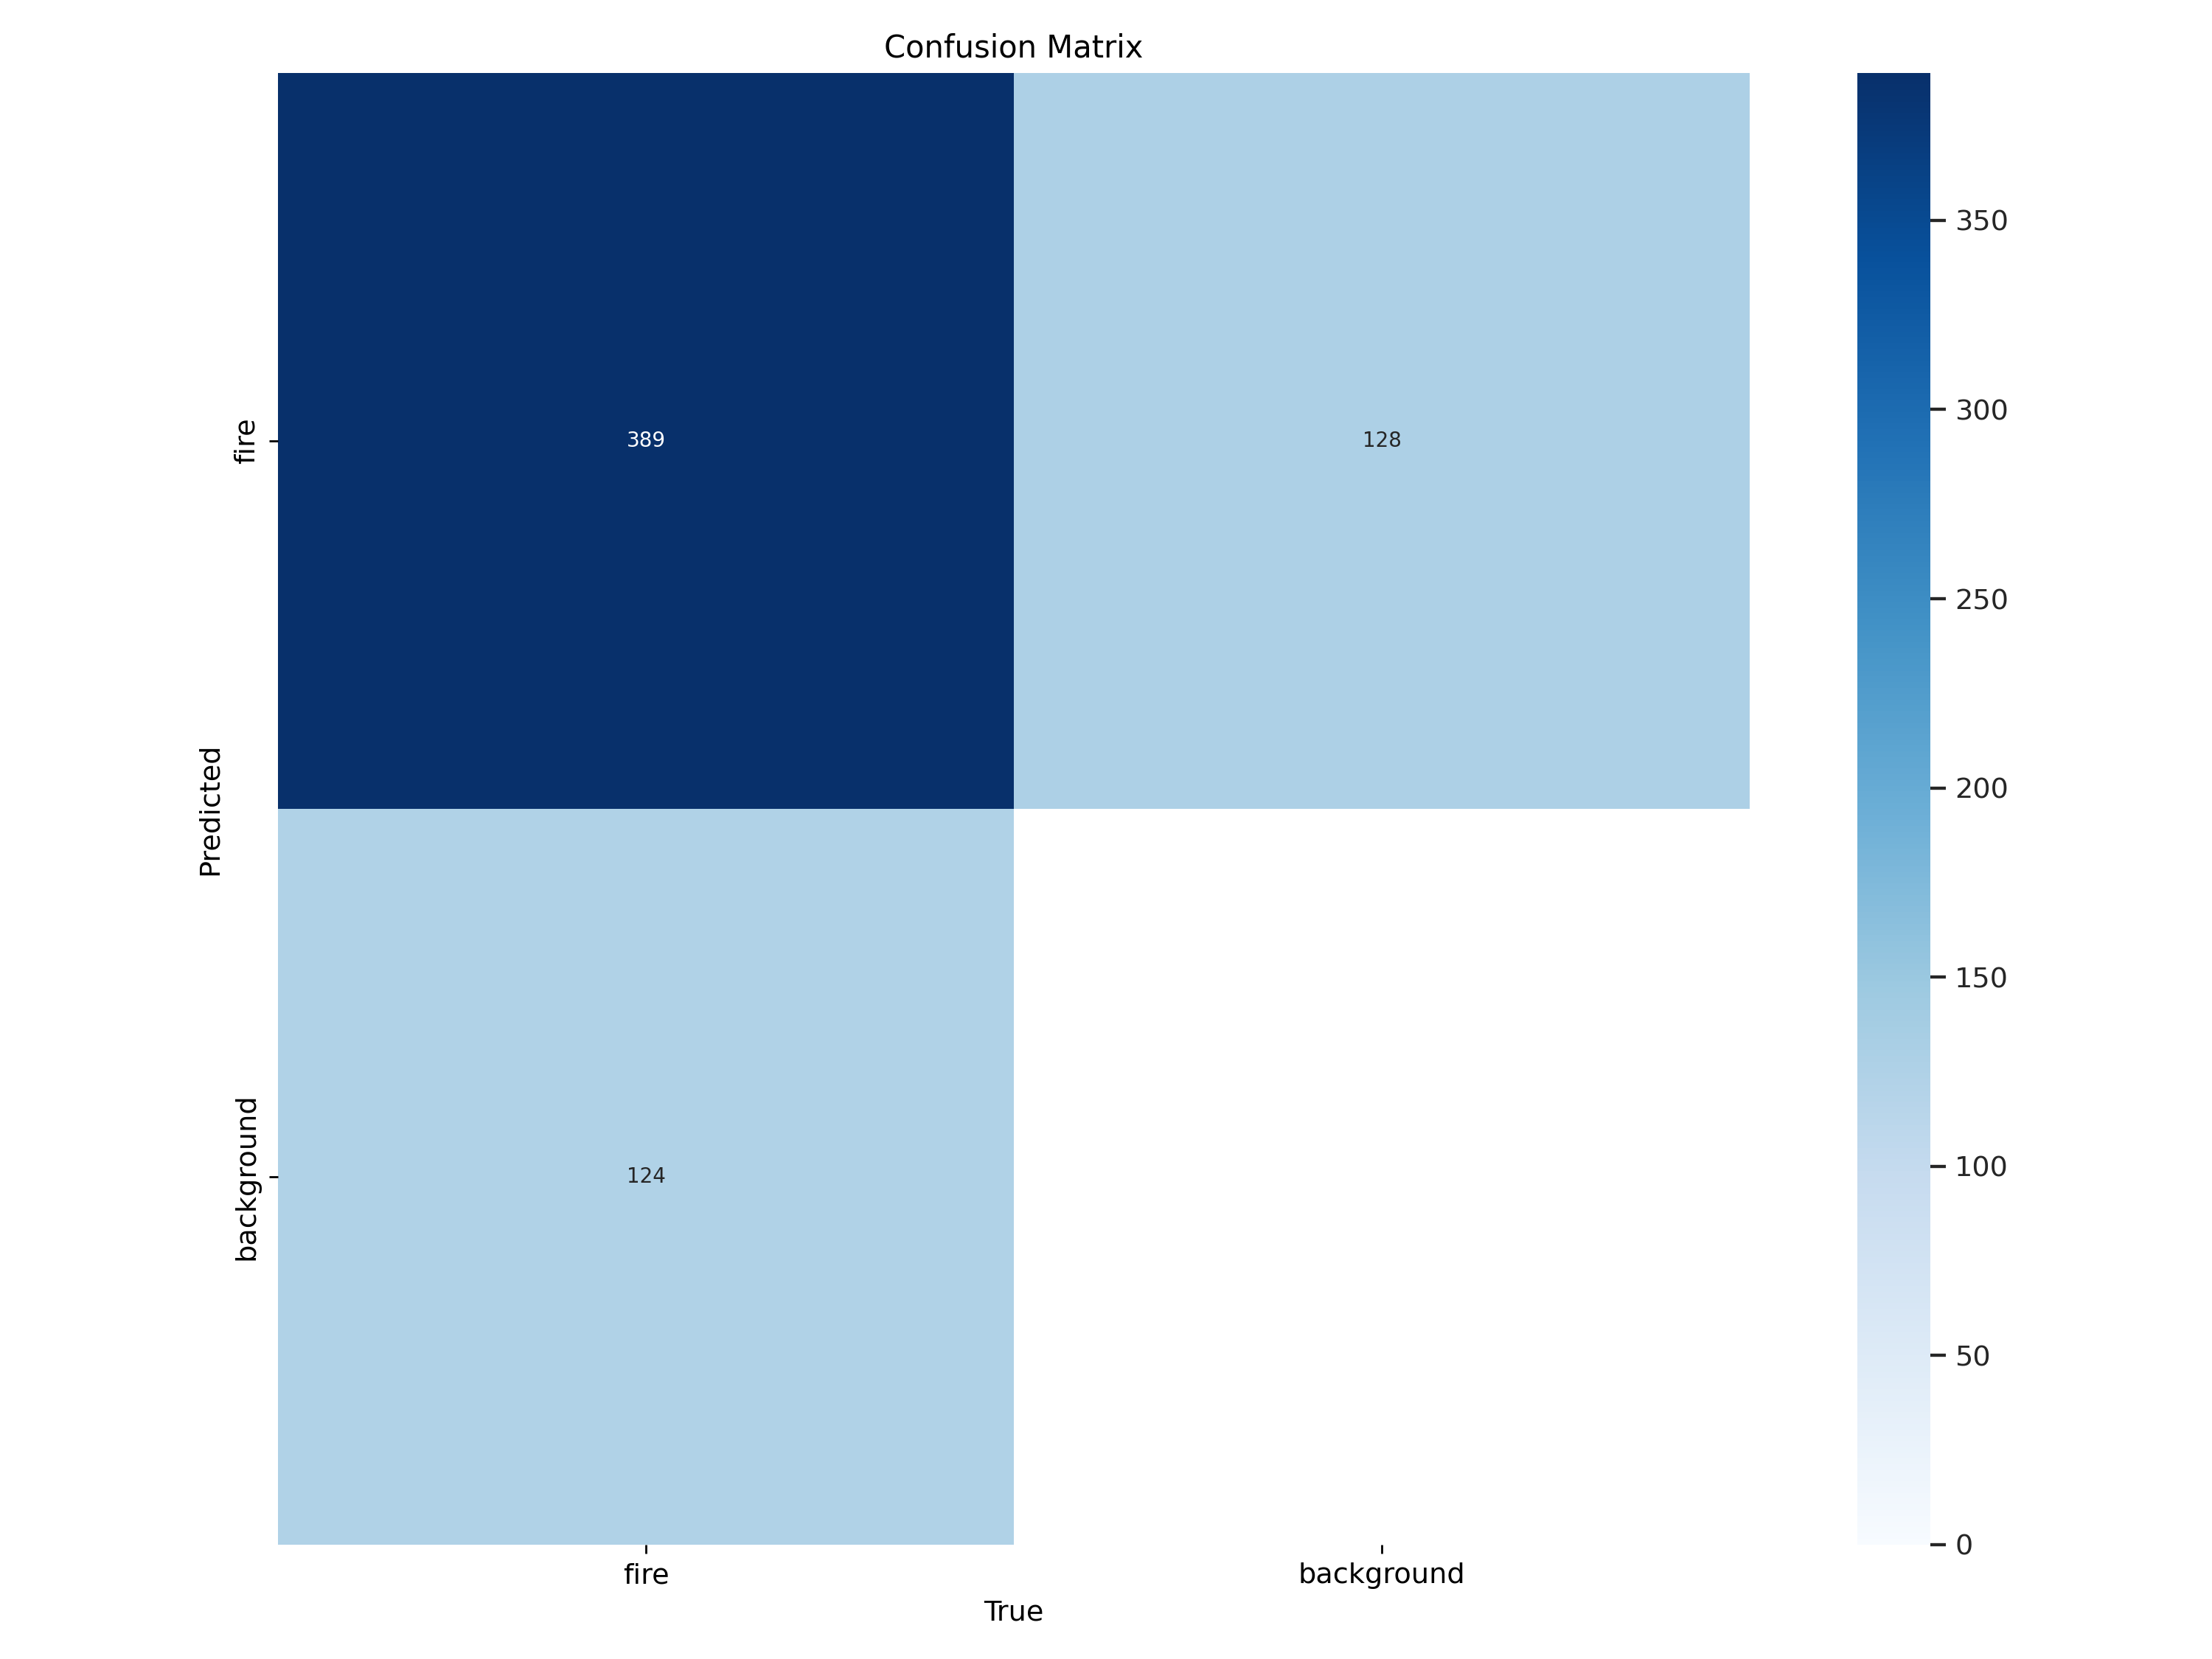

In [12]:
# Take a look at the confusion matrix of training results
from IPython.display import Image
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

#### Confusion Matrix Breakdown
- **True Positives (TP)**: The number of correctly predicted positive instances (fire); top-left cell indicating **389** true positive detections for fire.
- **True Negatives (TN)**: The number of correctly predicted negative instances (background); bottom-right cell showing the true negatives (0).
- **False Positives (FP)**: The number of incorrect predictions where the model predicted fire, but it was actually background; top-right cell indicating **128** false positive predictions.
- **False Negatives (FN)**: The number of incorrect predictions where the model predicted background, but it was actually fire; bottom-left cell showing **124** false negative predictions.

#### Metrics Calculation

Based on the confusion matrix, we can calculate the following:

1. **Precision** = TP/(TP + FP) = 389/(389 + 128) = 0.793
2. **Recall** = TP/(TP + FN) = 389/(389 + 124) = 0.758
3. **Accuracy** = (TP + TN)/(TP + TN + FP + FN) = 389/(389 + 128 + 124) = 0.607

## Load Trained Model

Once the model has been trained, the next step is to load it so that it can be used for making predictions. Loading the trained model allows us to evaluate its performance on a separate validation dataset that it has not seen during training. This helps us to assess how well the model generalizes to new, unseen data. In this section, we will load the best weights of the trained model and the validation dataset to visualize and evaluate the detection results.

### Steps Involved:
1. **Import Supervision Library:** We import the necessary functions from the `supervision` library which helps in handling the dataset and annotations.
2. **Load Best Model Weights:** We load the weights of the model that performed best during the training process. This is stored in a file `best.pt` in the `runs/detect/train/weights/` directory.
3. **Load Validation Dataset:** We load the validation dataset using the paths to images, annotations, and the data configuration file. This dataset will be used to evaluate the model's performance.
4. **Initialize Annotators:** We initialize two annotators: a bounding box annotator and a label annotator. These will help in visualizing the detection results by drawing bounding boxes and labels on the images.

In [13]:
# Load newly trained model

import supervision as sv

model = YOLOv10(f'{HOME}/runs/detect/train/weights/best.pt')

dataset = sv.DetectionDataset.from_yolo(
    #images_directory_path=f"{dataset.location}/valid/images",
    images_directory_path=f"{dataset.location}/valid/images",
    annotations_directory_path=f"{dataset.location}/valid/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()


0: 640x640 1 fire, 16.4ms
Speed: 4.0ms preprocess, 16.4ms inference, 179.6ms postprocess per image at shape (1, 3, 640, 640)


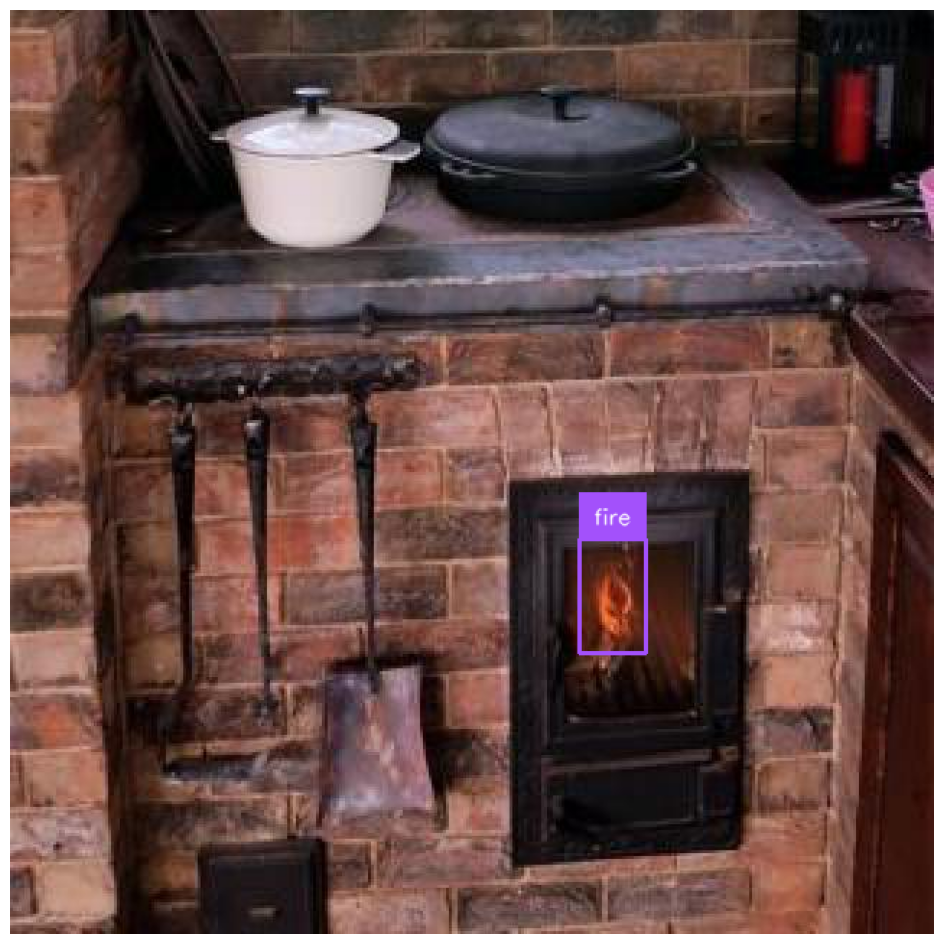

In [14]:
# Randomly select image from validation set and visualize the results

import random

random_image = random.choice(list(dataset.images.keys()))
random_image = dataset.images[random_image]

results = model(source=random_image, conf=0.25)[0]
detections = sv.Detections.from_ultralytics(results)

annotated_image = bounding_box_annotator.annotate(
    scene=random_image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

A randomly selected image from the validation set was processed by the model, correctly identifying the fire instance and annotated it with a bounding box and label. The Ember Eye project demonstrates then the effective application of computer vision techniques for early wildfire detection using the YOLOv10 model.